# Ensemble techniques for image classification models

<center><img src="images/ensemble.png", alt="Ensemble"/></center>

<br>

This notebook will load the pretrained models, create a function to combine the predictions of the models, apply the ensemble technique to the test set, and evaluate the performance of the ensemble model.

In [1]:
config = {
    "model_predictions_file_names": [
        "model_InceptionResNetV2_rgb_aug_predictions.npy",
        "model_Xception_rgb_aug_predictions.npy",
        "model_ResNet50_rgb_aug_predictions.npy",
        "model_VGG19_rgb_aug_predictions.npy",
    ]
}

In [2]:
def connect_to_resources() -> str:
    try:
        from google.colab import drive, files

        drive.mount('/content/drive')
        print('Running on COLAB')
        return '/content/drive/MyDrive/final_project'
    except ModuleNotFoundError:
        print('Not running on COLAB')
        return ''


ROOT = connect_to_resources()

Not running on COLAB


In [3]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Create a function to combine the predictions of the models
def get_ensemble_predictions(_predictions: list) -> np.ndarray:
    # Calculate the average of the predictions
    average_prediction = np.mean(np.array(_predictions), axis=0)
    return average_prediction


def plot_confusion_matrix(_confusion_matrix, classes: list,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=cm.Blues) -> None:
    if normalize:
        _confusion_matrix = _confusion_matrix.astype('float') / _confusion_matrix.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(7, 7))
    plt.imshow(_confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = _confusion_matrix.max() / 2.

    for i, j in itertools.product(range(_confusion_matrix.shape[0]), range(_confusion_matrix.shape[1])):
        plt.text(j, i, format(_confusion_matrix[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if _confusion_matrix[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
DATA_PATH = Path(ROOT, 'data')
PREDICTIONS_PATH = Path(DATA_PATH, 'predictions')
test_labels = pd.read_csv(Path(DATA_PATH, 'test_image_gen_classes.csv'))
confusion_matrix_plot_labels = pd.read_csv(
    Path(DATA_PATH, 'test_image_gen_class_indices.csv')).values.flatten().tolist()

In [6]:
predictions = [np.load(f) for f in [Path(PREDICTIONS_PATH, f) for f in config['model_predictions_file_names']]]

In [7]:
len(predictions)

3

# Ensemble Technique 1: Averaging

In [8]:
ensemble_predictions = get_ensemble_predictions(predictions)
ensemble_predictions[:5]

array([[0.38858667, 0.3560853 , 0.05768536, 0.05110939, 0.05511932,
        0.04754911, 0.04386486],
       [0.69762176, 0.0497552 , 0.05097143, 0.04897844, 0.06311335,
        0.04637939, 0.04318043],
       [0.0856861 , 0.07600072, 0.19107997, 0.08307499, 0.16776575,
        0.34667203, 0.04972041],
       [0.7109205 , 0.0498112 , 0.04825436, 0.04759238, 0.04769247,
        0.04790298, 0.04782608],
       [0.40894732, 0.07590399, 0.26347592, 0.05663252, 0.10401821,
        0.04623849, 0.04478355]], dtype=float32)

In [9]:
final_predictions = ensemble_predictions.argmax(axis=1)
final_predictions[:5]

array([0, 0, 5, 0, 0], dtype=int64)

Normalized confusion matrix


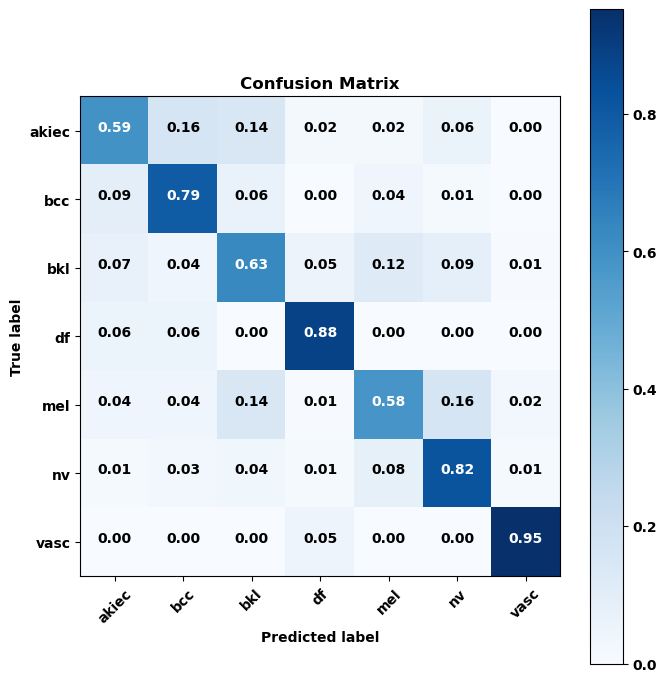

In [10]:
conf_matrix = confusion_matrix(test_labels, final_predictions)
plot_confusion_matrix(conf_matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)

In [11]:
# Creating classification report
report = classification_report(test_labels, final_predictions, zero_division=0)

print('Classification Report:')
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.59      0.50        49
           1       0.55      0.79      0.65        77
           2       0.59      0.63      0.61       164
           3       0.38      0.88      0.54        17
           4       0.48      0.58      0.52       166
           5       0.95      0.82      0.88      1005
           6       0.51      0.95      0.67        21

    accuracy                           0.77      1499
   macro avg       0.56      0.75      0.62      1499
weighted avg       0.81      0.77      0.78      1499



Conclusion 1:

This is a basic form of model averaging ensemble technique. In this approach, multiple models are trained independently on the same dataset, and their predictions are averaged to generate the final prediction.

In this particular implementation, we load multiple pretrained CNN models and predict the labels of the testing images using each model. The predictions of each model are then averaged to generate the final prediction for each image. By averaging the predictions of multiple models, we hope to reduce the variance in the predictions and improve the overall accuracy of the ensemble.

---
# Ensemble Technique 2: Voting

Normalized confusion matrix
              precision    recall  f1-score   support

       akiec       0.34      0.63      0.44        49
         bcc       0.45      0.77      0.56        77
         bkl       0.56      0.59      0.58       164
          df       0.48      0.82      0.61        17
         mel       0.47      0.59      0.52       166
          nv       0.96      0.80      0.87      1005
        vasc       0.67      0.95      0.78        21

    accuracy                           0.75      1499
   macro avg       0.56      0.74      0.62      1499
weighted avg       0.81      0.75      0.77      1499



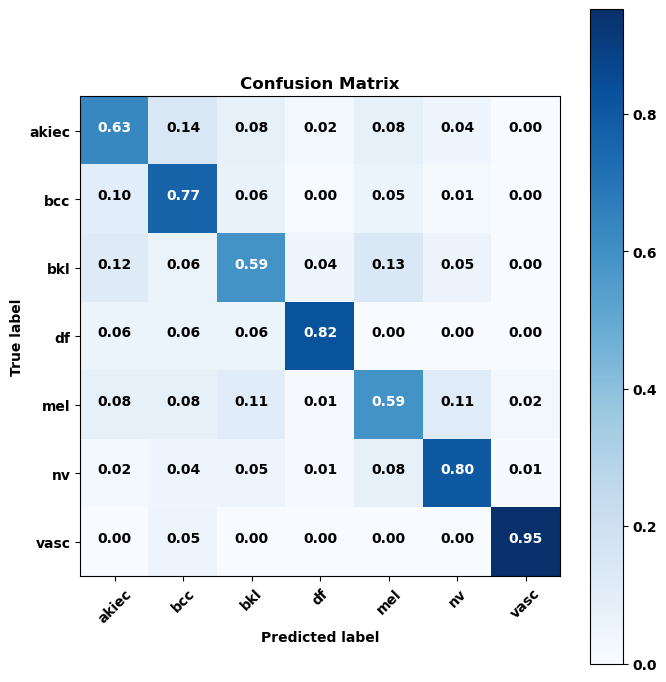

In [12]:
preds = []

for i in predictions:
    preds.append(np.argmax(i, axis=1))

# Compute the mode (most common value) for each image across the predictions
mode_preds = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=preds)

# Compute the classification report and confusion matrix
report = classification_report(test_labels, mode_preds, target_names=confusion_matrix_plot_labels)
matrix = confusion_matrix(test_labels, mode_preds)

# Print the classification report and confusion matrix
plot_confusion_matrix(matrix, confusion_matrix_plot_labels, title='Confusion Matrix', normalize=True)
print(report)

Conclusion 2:

The ensemble technique used above is called voting. Voting is a simple but effective ensemble technique that combines the predictions of multiple models by taking a majority vote. In the example notebook, the predictions of three CNN models are combined to produce a single prediction. The model with the highest prediction score for each image is selected as the ensemble prediction.

Voting is a robust ensemble technique that can be used with a variety of machine learning models. It is particularly effective for reducing the variance of a model, which can lead to improved accuracy.

Tie-breaking is solved by sorting labels in ascending order and selecting the first label.

Here are some of the advantages of using voting as an ensemble technique:
- It is simple to implement.
- It is effective for reducing variance.
- It can be used with a variety of machine learning models.

Here are some of the disadvantages of using voting as an ensemble technique:
- It may not improve accuracy as much as other ensemble techniques.
- It can be computationally expensive to train multiple models.

Overall, voting is a simple and effective ensemble technique that can be used to improve the accuracy of machine learning models.